# Metyis selection process Project

Josep Reverter Sancho - Data Scientist

Metyis selection process project

Data: Brazilian E-Commerce Public Dataset by Olist (https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)


A client who owns a **company** dedicated to **online sales of all kinds of products** has commissioned us to carry out a **Data Science** project that provides value to their business.

We believe that for this type of business, it would be highly valuable to implement solutions that, on one hand, support operations and logistics, and on the other hand, allow us to analyze customer behavior and draw insights about how they act. This would help generate business ideas and take strategic actions based on their behavior.

To achieve this, we decided to develop a **sales forecasting model**, as it is a key tool for predicting future sales, improving inventory control, and optimizing operations, logistics, and costs.
Based on this sales forecasting model, we will calculate the **optimal price for different products** in order to maximize revenue.
Lastly, we will apply a **clustering algorithm** to segment the different types of customers the online store has. This will help us better understand their behavior and define targeted actions for each segment in the future.


**Notebook parts: Sales Forecasting - Regression**
1. Data processing
2. Basic Exploratory Data Analysis
3. Sales Forecasting Model -> Feature Engineering, Model training, Results Analysis
4. Price Optimization




## Sales Forecasting - Regression

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)

### 1. Data processing

We have data about the orders, the items in each order, products, and customers.
Regarding the customers, we don’t have much information — only the city and state they come from.
We also have limited information about the products, as we don’t have their names, but we do have a unique identifier for each product and the category it belongs to.
On the other hand, we have a lot of information about orders and items. The most important variables for our purposes are the order date, price, customer, and product.

In [104]:
# load data tables: customers, orders, items, and product information
customers_df = pd.read_csv('data/olist_customers_dataset.csv')
# order and product relationship, with price, seller, shipping, etc.
order_items_df = pd.read_csv('data/olist_order_items_dataset.csv')
orders_df = pd.read_csv('data/olist_orders_dataset.csv')
products_df = pd.read_csv('data/olist_products_dataset.csv')

In [105]:
# merge dataframes to create a single dataframe with all relevant information
orders_customers_df = pd.merge(orders_df, customers_df, on='customer_id', how='left')

# here we are at a product level
df = pd.merge(order_items_df, orders_customers_df, on='order_id', how='left')
df = pd.merge(df, products_df, on='product_id', how='left')

# translate product category names to English
translation_df = pd.read_csv('data/product_category_name_translation.csv')
translation_dict = dict(zip(translation_df["product_category_name"], translation_df["product_category_name_english"]))
df["product_category_name"] = df["product_category_name"].replace(translation_dict)

# edit important date columns to have datetime format and date only
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
# df["order_purchase"] = pd.to_datetime(df["order_purchase_timestamp"]).dt.date
df["order_purchase"] = pd.to_datetime(df["order_purchase_timestamp"]).dt.date

df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_purchase
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,2017-09-13
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,2017-04-26
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,furniture_decor,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,2018-01-14
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,perfumery,42.0,480.0,1.0,200.0,16.0,10.0,15.0,2018-08-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,garden_tools,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,2017-02-04


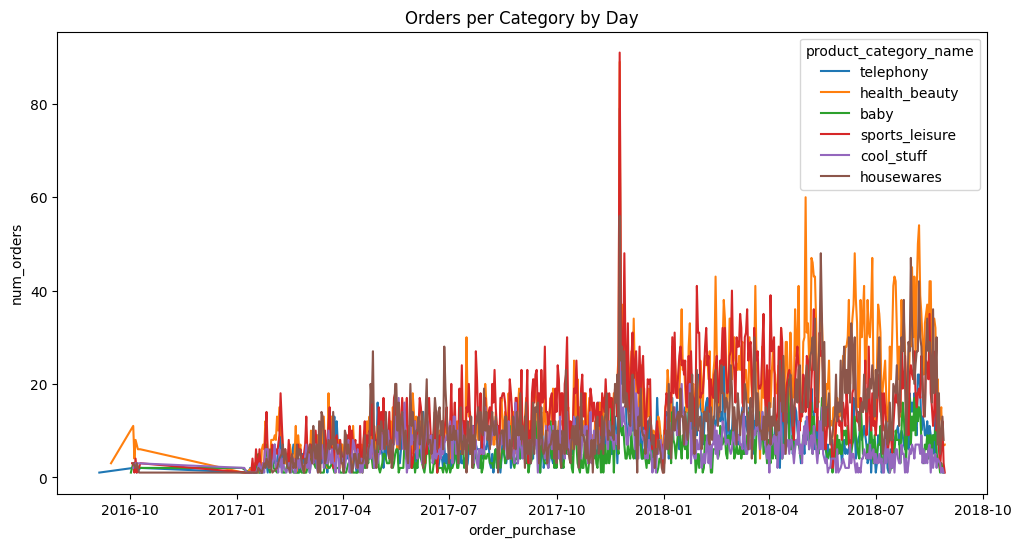

In [106]:
def plot_orders_by_category(data, date_col, category_cols):
    data = data[data["product_category_name"].isin(category_cols)]
    grouped = data.groupby(["order_purchase","product_category_name"]).size().reset_index(name="num_orders")
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=grouped, x='order_purchase', y='num_orders', hue="product_category_name")
    plt.title("Orders per Category by Day")
    plt.show()

plot_orders_by_category(df, "order_purchase", ["telephony","baby","cool_stuff","health_beauty", "sports_leisure","housewares"])

We can see that sales across the different product groups behave in a very similar way. However, to achieve maximum accuracy in our predictions, it would be advisable to build a separate model for each product. This approach makes a lot of sense, especially for products with clear seasonality, and because some products are purchased much more frequently than others. Including all products in a single model would introduce noise, resulting in overly generic predictions that would not provide meaningful value for inventory management.

In this example, we will focus on the **Health and Beauty** product group.

In [107]:
# filtering by a specific product category, if needed
df = df[df["product_category_name"]== "health_beauty"]

In [108]:
df

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_purchase
8,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65,16150771dfd4776261284213b89c304e,delivered,2018-03-19 18:40:33,2018-03-20 18:35:21,2018-03-28 00:37:42,2018-03-29 18:17:31,2018-03-29 00:00:00,639d23421f5517f69d0c3d6e6564cf0e,11075,santos,SP,health_beauty,59.0,493.0,1.0,2000.0,30.0,12.0,16.0,2018-03-19
10,00061f2a7bc09da83e415a52dc8a4af1,1,d63c1011f49d98b976c352955b1c4bea,cc419e0650a3c5ba77189a1882b7556a,2018-03-29 22:28:09,59.99,8.88,c6fc061d86fab1e2b2eac259bac71a49,delivered,2018-03-24 22:16:10,2018-03-24 22:28:09,2018-03-27 05:26:55,2018-03-29 00:04:19,2018-04-09 00:00:00,107e6259485efac66428a56f10801f4f,13419,piracicaba,SP,health_beauty,57.0,614.0,1.0,950.0,35.0,25.0,20.0,2018-03-24
48,001d8f0e34a38c37f7dba2a37d4eba8b,1,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,2017-05-18 17:35:11,18.99,7.78,d987da9fb4086ab7c2c0f83963cd6722,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24 00:00:00,870a0bdc769f9a7870309036740e79ea,2929,sao paulo,SP,health_beauty,47.0,1474.0,3.0,150.0,43.0,13.0,14.0,2017-05-14
49,001d8f0e34a38c37f7dba2a37d4eba8b,2,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,2017-05-18 17:35:11,18.99,7.78,d987da9fb4086ab7c2c0f83963cd6722,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24 00:00:00,870a0bdc769f9a7870309036740e79ea,2929,sao paulo,SP,health_beauty,47.0,1474.0,3.0,150.0,43.0,13.0,14.0,2017-05-14
53,001e7cf2ad6bef3ade12ebc56ceaf0f3,1,bdcf6a834e8faa30dac3886c7a58e92e,2a84855fd20af891be03bc5924d2b453,2018-05-22 10:59:50,35.90,15.20,d1684ed69f8fd574b7c344de923f379a,delivered,2018-05-19 10:29:23,2018-05-19 10:59:50,2018-05-21 14:34:00,2018-06-04 18:08:23,2018-06-05 00:00:00,43860f86362fea12550bfa19ef73015f,38550,coromandel,MG,health_beauty,26.0,394.0,1.0,1614.0,31.0,16.0,28.0,2018-05-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112566,ffce8a2dd7579795f5c1cbe2bf23d51d,1,00878d953636afec00d3e85d55a12e7f,955fee9216a65b617aa5c0531780ce60,2018-05-09 21:15:18,100.00,26.78,4b80c7d4d1810bb81823061e2d14ed1c,delivered,2018-05-07 21:04:46,2018-05-07 21:15:48,2018-05-09 06:34:00,2018-05-14 12:41:36,2018-05-24 00:00:00,efd83b0793ba3de2948e93d34dbf7b34,84010,ponta grossa,PR,health_beauty,59.0,1631.0,4.0,2550.0,38.0,42.0,25.0,2018-05-07
112589,ffdd178654127ccf34a439e8704fecd9,1,16b4473e98422039c388f144a0b16f55,4de6e4ba574aa9dfdc824bc44dc47fdd,2018-03-13 14:29:47,69.90,38.71,33d0814c9eff200629eb49330ce5c6a3,delivered,2018-03-07 14:07:47,2018-03-07 14:29:47,2018-03-09 01:43:26,2018-04-07 13:16:50,2018-04-04 00:00:00,57e2b4ad2d77ceb7034ddaf45564600d,57017,maceio,AL,health_beauty,57.0,1293.0,1.0,2350.0,28.0,10.0,16.0,2018-03-07
112595,ffe146c862ce518ad378598499bf9204,1,8ab83b53b9a953395f4f21f0b1a845ef,431050a06a317f2b38168dec3dcd2b46,2018-07-04 22:10:03,83.80,18.69,f813294c06241ae2660aa359c74e1d5f,delivered,2018-06-28 21:44:06,2018-06-28 22:10:03,2018-07-03 13:39:00,2018-07-14 07:04:34,2018-07-26 00:00:00,1bf1788a9e4d31061c61c925634002e6,75813,cacu,GO,health_beauty,38.0,702.0,1.0,150.0,16.0,16.0,11.0,2018-06-28
112614,ffec1a6d35149778ec575d5048d44db8,1,437c05a395e9e47f9762e677a7068ce7,f84fa566034f5e8e880a07ec624c56af,2018-03-28 02:49:46,47.65,7.39,970ca115b43314d95949db28ed73aa78,delivered,2018-03-20 12:47:53,2018-03-22 02:49:46,2018-03-27 17:06:34,2018-03-28 1

### 2. First EDA

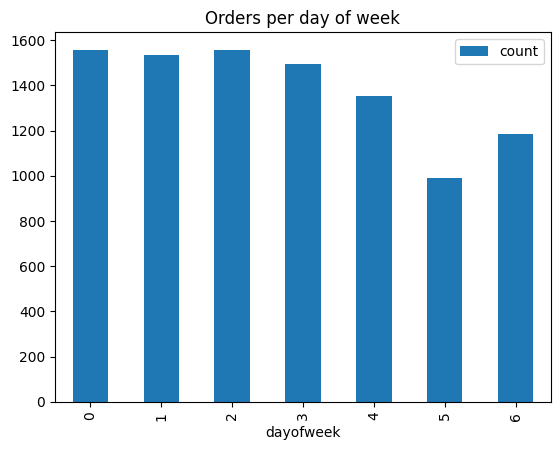

In [138]:
# plotting orders per day of wee
df_dayorder = df[["order_purchase", "order_id"]].copy()
df_dayorder.index = pd.to_datetime(df["order_purchase"])
df_dayorder["dayofweek"] = df_dayorder.index.dayofweek
df_day = df_dayorder[["dayofweek", "order_purchase"]].groupby("dayofweek").agg(count=("order_purchase", "count"))
df_day.plot(kind="bar")
plt.title("Orders per day of week")
plt.show()

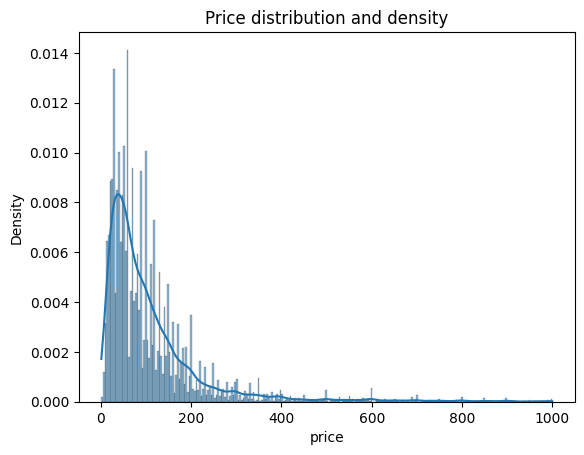

The average price per order is: 121€
The median is: 75€


In [48]:
# plot the price distribution
sns.histplot(df[df["price"]<1000]["price"], kde=True, stat="density")
plt.title("Price distribution and density")
plt.show()
print(f"The average price per order is: {np.mean(df['price']):.0f}€")
print(f"The median is: {np.median(df['price']):.0f}€")

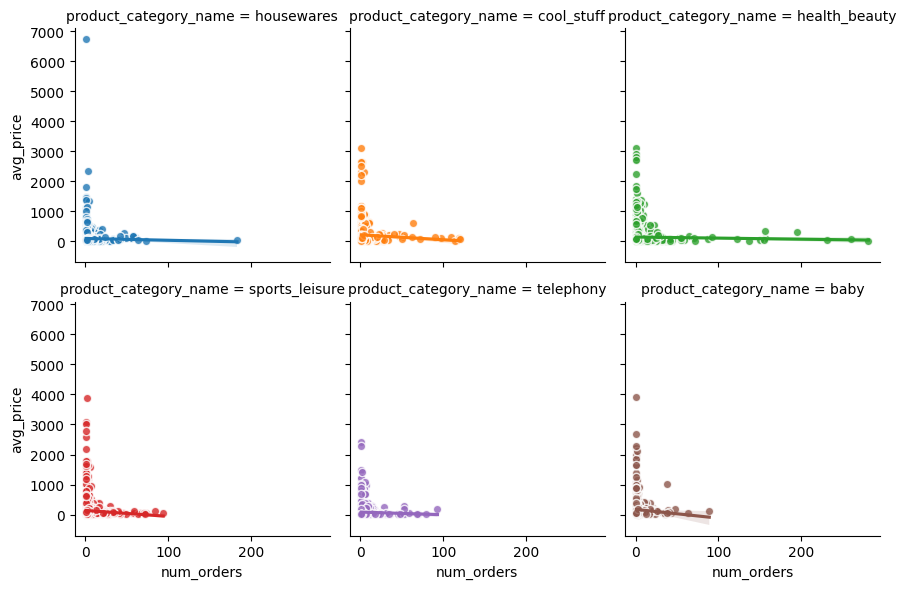

In [77]:
# creating dataframe with price and prders per product and product group
group_product = df[["product_id","product_category_name","order_id","price"]].groupby(["product_id","product_category_name"]).agg(
    avg_price=("price","mean"), num_orders=("order_id","count"), num_prices=("price",pd.Series.nunique)
    )
group_product = group_product.reset_index()
group_product = group_product[group_product["product_category_name"].isin(["telephony","baby","cool_stuff","health_beauty", "sports_leisure","housewares"])]

# price per product
sns.lmplot(data=group_product, x="num_orders", y="avg_price", col="product_category_name", hue="product_category_name",scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=3)
plt.show()

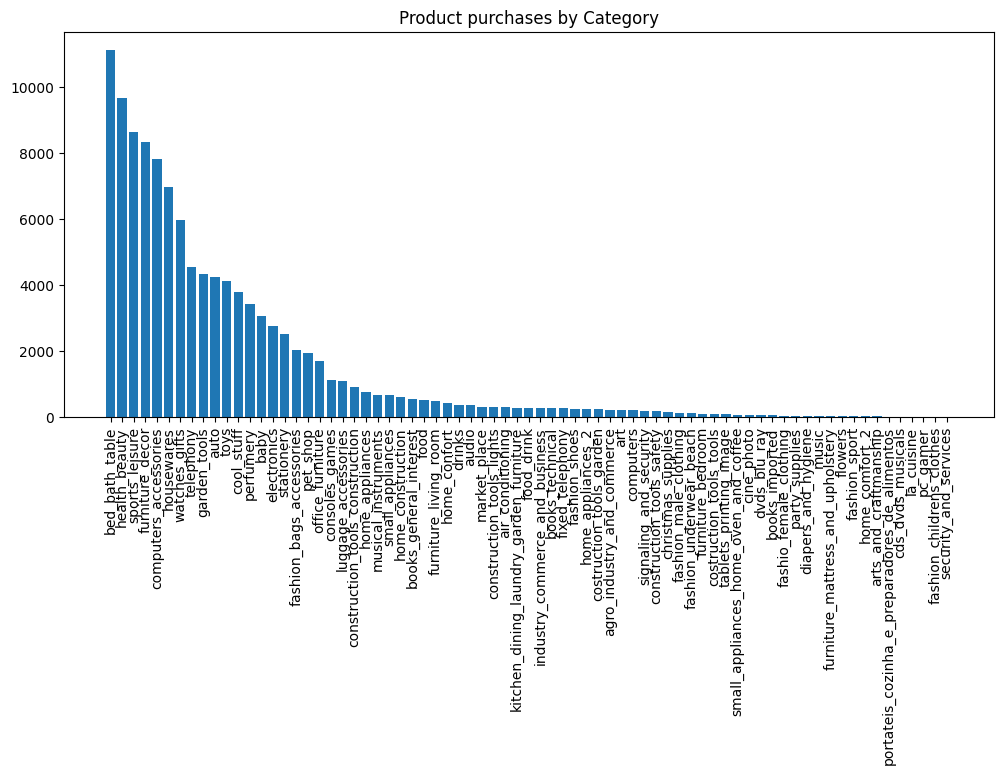

In [76]:
group_category = df[["product_category_name","product_id", "price"]].groupby("product_category_name").count()
group_category = group_category.reset_index().sort_values(by="product_id", ascending=False)

# plot product purchases by category
plt.figure(figsize=(12, 5))
plt.bar(group_category["product_category_name"], group_category["product_id"])
plt.xticks(group_category["product_category_name"], rotation=90)
plt.title("Product purchases by Category")
plt.show()

### 3. Sales Forecasting

We now develop the sales forecasting model, which aims to predict future sales for the days following a given date. This will allow the client to forecast sales for the next day, week, month, and so on.

To do this, we created a daily-level dataframe. We generated the most relevant features we considered, including time-based features, past sales, and past prices.
In particular, we made sure to avoid highly correlated features in order to prevent adding unnecessary complexity to the model.



In [155]:
# Sales per Day Dataframe: create a dataframe with the sales per day and the average price
spd_df = df.groupby('order_purchase').agg(
    num_purchases=('price', 'count'),
    avg_price=('price', 'mean')
).reset_index()

spd_df["order_purchase"] = pd.to_datetime(spd_df["order_purchase"])

# filtering the relevant time period that we are interested in
spd_df = spd_df[(spd_df["order_purchase"]>"2017-01-01") & (spd_df["order_purchase"]<"2018-08-01")]

# setting the date as index
spd_df = spd_df.set_index("order_purchase")


#### 3.1. Feature Engineering

In [156]:
def create_features(df):
    """
    Create time features based on datetime index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)  # 1 if Sat/Sun, else 0

    return df

# Create time features
spd_df = create_features(spd_df)

def add_lags(df, col, lags=[1, 2, 3, 7, 14]):
    for lag in lags:
        df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return df

# Add lag features
spd_df = add_lags(spd_df, "num_purchases")
spd_df = add_lags(spd_df, "avg_price")

def add_rolling_features(df, col, windows=[3, 7, 14]):
    for window in windows:
        df[f"{col}_roll_mean_{window}"] = df[col].shift(1).rolling(window).mean()
    return df

# Add rolling features
spd_df = add_rolling_features(spd_df, "num_purchases")

In [157]:
# TODO: info(), see nans, describe(), etc.

spd_df = spd_df.dropna()
spd_df.shape

(551, 21)

The correlation matrix is a very useful tool for identifying relationships between the different features and the target variable (num_purchases). It also helps us detect highly correlated features, which can sometimes negatively impact the performance of our model.

For example, we observed strong correlations between: quarter and month, quarter and weekofyear, dayofweek and is_weekend.

These types of correlations are important to consider when selecting and engineering features.

In [158]:
# plotting correlation matrix
spd_df.corr().style.background_gradient(cmap='coolwarm', axis=None)

,num_purchases,avg_price,dayofweek,quarter,month,dayofmonth,weekofyear,is_weekend,num_purchases_lag_1,num_purchases_lag_2,num_purchases_lag_3,num_purchases_lag_7,num_purchases_lag_14,avg_price_lag_1,avg_price_lag_2,avg_price_lag_3,avg_price_lag_7,avg_price_lag_14,num_purchases_roll_mean_3,num_purchases_roll_mean_7,num_purchases_roll_mean_14
num_purchases,1.000000,-0.031725,-0.194114,-0.023674,-0.024577,-0.041553,-0.021248,-0.208740,0.705142,0.607465,0.546297,0.624931,0.508080,-0.026902,-0.022612,0.004473,-0.001719,-0.050715,0.700397,0.732822,0.695522
avg_price,-0.031725,1.000000,0.013747,-0.016817,-0.006026,-0.034852,-0.009483,0.006191,-0.005236,-0.056492,-0.073106,-0.045526,-0.015572,0.054630,0.015143,0.071006,-0.029755,-0.094170,-0.050796,-0.060585,-0.039905
dayofweek,-0.194114,0.013747,1.000000,0.009378,0.014781,-0.013893,-0.007390,0.791251,-0.067932,0.135902,0.155227,-0.188752,-0.181277,0.025289,0.001911,-0.057796,0.004391,0.007376,0.084070,0.001489,0.000895
quarter,-0.023674,-0.016817,0.009378,1.000000,0.965786,-0.003487,0.962309,0.014168,-0.024177,-0.022001,-0.011347,0.009980,0.035290,-0.020818,-0.024275,-0.034729,-0.038327,-0.075532,-0.021673,-0.008583,0.011995
month,-0.024577,-0.006026,0.014781,0.965786,1.000000,-0.009996,0.995491,0.011910,-0.020417,-0.014533,-0.006220,0.021428,0.050083,-0.009710,-0.011734,-0.019937,-0.009260,-0.037644,-0.015512,-0.001786,0.025983
dayofmonth,-0.041553,-0.034852,-0.013893,-0.003487,-0.009996,1.000000,0.082191,-0.006787,-0.008585,0.023805,0.014790,0.008599,0.066900,-0.070349,-0.053737,-0.037920,0.070190,0.069914,0.011302,0.029710,0.041598
weekofyear,-0.021248,-0.009483,-0.007390,0.962309,0.995491,0.082191,1.000000,-0.005183,-0.016717,-0.012200,-0.005226,0.028590,0.062131,-0.016594,-0.016551,-0.022054,-0.002693,-0.031433,-0.012864,0.004332,0.032959
is_weekend,-0.208740,0.006191,0.791251,0.014168,0.011910,-0.006787,-0.005183,1.000000,-0.139422,0.033975,0.110449,-0.200252,-0.194073,0.049527,0.034120,-0.053307,-0.006020,-0.005739,0.001866,0.002282,0.003199
num_purchases_lag_1,0.705142,-0.005236,-0.067932,-0.024177,-0.020417,-0.008585,-0.016717,-0.139422,1.000000,0.704769,0.609976,0.604341,0.496070,-0.031966,-0.029381,-0.026127,0.021324,-0.023790,0.872170,0.799065,0.740779
num_purchases_lag_2,0.607465,-0.056492,0.135902,-0.022001,-0.014533,0.023805,-0.012200,0.033975,0.704769,1.000000,0.707451,0.568902,0.476336,-0.005422,-0.034450,-0.032950,0.011007,-0.065584,0.908809,0.817364,0.760060


#### 3.2. Model Training

For model training, we selected the features we considered most appropriate and defined the target variable.

In [ ]:
# name of features we decided to use regarding the correlation matrix and the EDA
FEATURES = ['avg_price', 'dayofweek', 'month',
       'dayofmonth', #'is_weekend', # 'post_2018',
       'num_purchases_lag_3', 'num_purchases_lag_7', 'num_purchases_lag_14',
       #'num_purchases_lag_1', 'num_purchases_lag_2', 'num_purchases_lag_3',
       'avg_price_lag_1', 'avg_price_lag_2','avg_price_lag_3', 'avg_price_lag_7', 'avg_price_lag_14',
       'num_purchases_roll_mean_3', 'num_purchases_roll_mean_7','num_purchases_roll_mean_14'
       ]

# target variable
TARGET = "num_purchases"

# create X and y
X = create_features(spd_df[FEATURES])
X = X[FEATURES]
y = spd_df[TARGET]

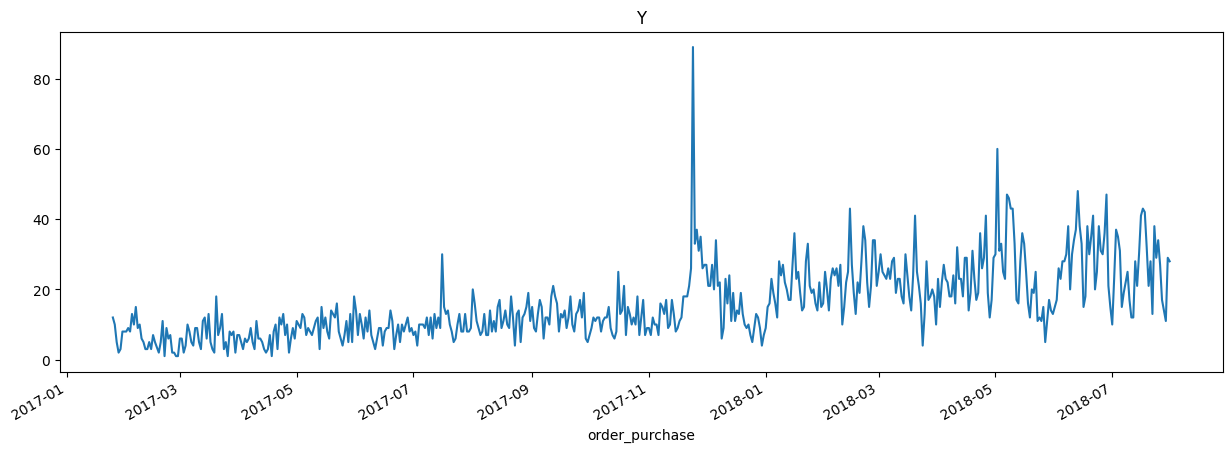

In [159]:
# plotting the y data
fig, ax = plt.subplots(figsize=(15, 5))
y.plot(ax=ax, label='Data', title='Y')
plt.show()

As we can see, the data volume varies significantly over time (concept drift). For this reason, applying a **cross-validation split** is a good approach. It allows us to evaluate how well the model generalizes and whether it remains consistent and robust across different time periods.



In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

tscv = TimeSeriesSplit(n_splits=5)

folds_list = []
rmse_list = []

# start cross-validation algorithm, to train a different models for each fold
for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"\nFold {fold+1}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # define a regularized XGBoost model
    reg = xgb.XGBRegressor(
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=3,
        min_child_weight=10,
        subsample=0.7,
        colsample_bytree=0.7,
        gamma=5,
        reg_alpha=0.5,
        reg_lambda=1.0,
        objective='reg:squarederror',
        early_stopping_rounds=50,
        random_state=42
    )

    # fit the model
    reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=100)

    # make predictions and calculate RMSE
    y_pred = reg.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    # append the results to the lists for later analysis
    folds_list.append(fold+1)
    rmse_list.append(rmse)

    print(f"Fold {fold+1} RMSE: {rmse:.4f}")


Fold 1
[0]	validation_0-rmse:5.03392
[100]	validation_0-rmse:4.94812
[151]	validation_0-rmse:4.98531
Fold 1 RMSE: 4.9470

Fold 2
[0]	validation_0-rmse:5.61442
[100]	validation_0-rmse:5.03837
[200]	validation_0-rmse:4.76175
[300]	validation_0-rmse:4.64110
[400]	validation_0-rmse:4.64529
[401]	validation_0-rmse:4.64412
Fold 2 RMSE: 4.6170

Fold 3
[0]	validation_0-rmse:14.00155
[100]	validation_0-rmse:13.42203
[200]	validation_0-rmse:13.06760
[300]	validation_0-rmse:12.87962
[400]	validation_0-rmse:12.77481
[480]	validation_0-rmse:12.73429
Fold 3 RMSE: 12.7309

Fold 4
[0]	validation_0-rmse:13.29214
[100]	validation_0-rmse:7.94780
[200]	validation_0-rmse:6.89674
[300]	validation_0-rmse:6.77426
[400]	validation_0-rmse:6.75065
[418]	validation_0-rmse:6.76290
Fold 4 RMSE: 6.7373

Fold 5
[0]	validation_0-rmse:16.73590
[100]	validation_0-rmse:12.06390
[200]	validation_0-rmse:10.64463
[300]	validation_0-rmse:10.23325
[400]	validation_0-rmse:10.06509
[500]	validation_0-rmse:10.00703
[543]	valida

We applied a 5-fold cross-validation and observed differences in performance between folds. This suggests that the model performs well in certain time periods but struggles in others, due to factors such as seasonality, promotional effects, or variations in product demand.

These insights are valuable, as they highlight the importance of further exploring time-specific patterns or even building more specialized models for certain product groups or seasons.

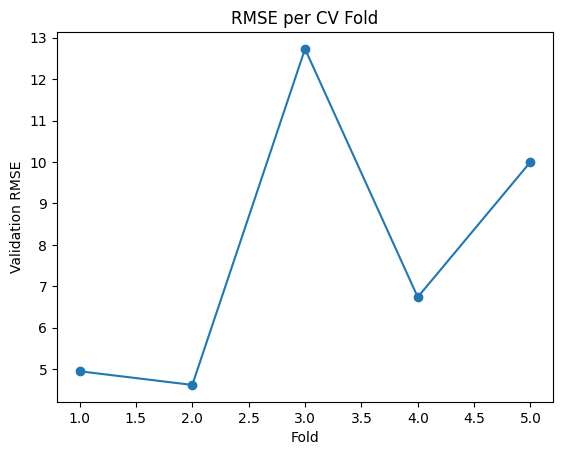

In [ ]:
# plot cross-validation results
plt.plot(folds_list, rmse_list, marker='o')
plt.title("RMSE per CV Fold")
plt.xlabel("Fold")
plt.ylabel("Validation RMSE")
plt.show()

Although we know that the model might perform slightly worse on the most recent data, this is ultimately the data we are most interested in. Therefore, we decided to make a split on a specific date in order to predict the following two months — which correspond to the last period available in our dataset.

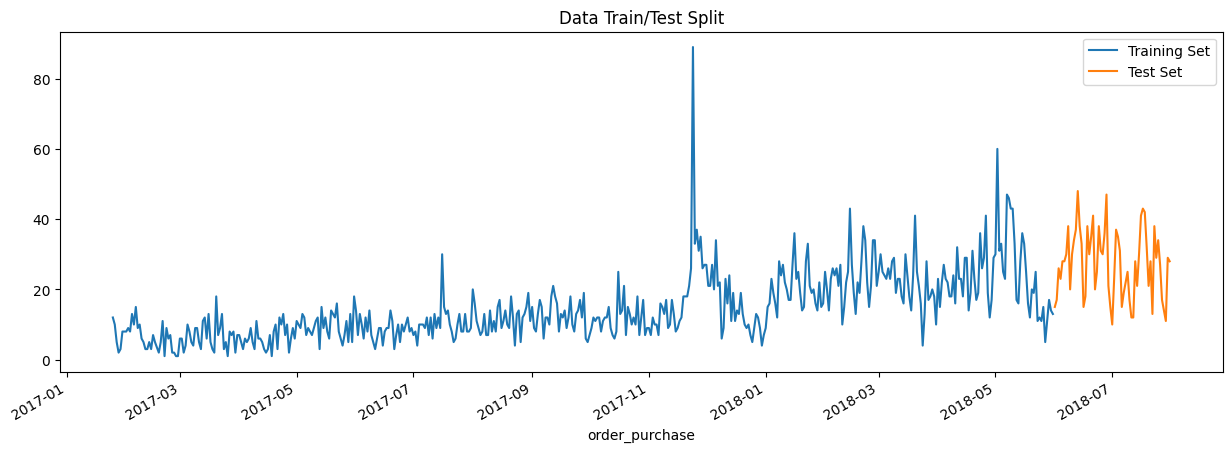

In [ ]:
# train-test split function given a fixed date
def train_test_split(data_X, data_y, date):
    X_train = data_X[data_X.index < date]
    X_test = data_X[data_X.index >= date]
    y_train = data_y[data_y.index < date]
    y_test = data_y[data_y.index >= date]
    return X_train, X_test, y_train, y_test

# train-test split by a fixed date
X_train, X_test, y_train, y_test = train_test_split(X, y, "2018-06-01")

# plot the test and train sets
fig, ax = plt.subplots(figsize=(15, 5))
y_train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
y_test.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [160]:
# define a regularized XGBoost model
reg = xgb.XGBRegressor(
    n_estimators=1000,              
    learning_rate=0.01,             
    max_depth=3,                    
    min_child_weight=10,            
    gamma=5,                        
    subsample=0.7,                  
    colsample_bytree=0.7,           
    reg_alpha=0.5,                  
    reg_lambda=1.0,                 
    early_stopping_rounds=150,
    objective='reg:squarederror',
    random_state=42,
    verbosity=1
)

# fit the model
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:9.43166	validation_1-rmse:16.02064
[100]	validation_0-rmse:6.36810	validation_1-rmse:10.47711
[200]	validation_0-rmse:5.45903	validation_1-rmse:9.00463
[300]	validation_0-rmse:5.04610	validation_1-rmse:8.74605
[400]	validation_0-rmse:4.77562	validation_1-rmse:8.72665
[500]	validation_0-rmse:4.51814	validation_1-rmse:8.73067
[600]	validation_0-rmse:4.29577	validation_1-rmse:8.77429
[613]	validation_0-rmse:4.26848	validation_1-rmse:8.77154


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=150,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#### 3.3. Results Analysis

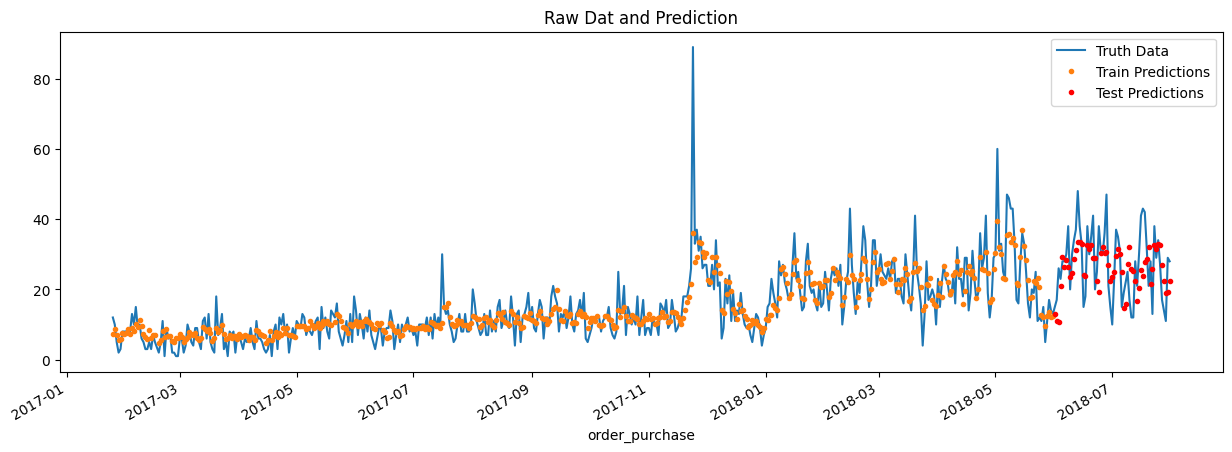

In [126]:
# calculating train predictions and saving them in a dataframe with the actual values, for later comparison
X_train_comp = X_train.copy()
X_train_comp["prediction"] = reg.predict(X_train_comp)
comp = pd.DataFrame({"Predictions": X_train_comp["prediction"],"Actual": y_train})# .plot(title="Train Predictions vs Actual", figsize=(15, 5))

# calculating test predictions and saving them in a dataframe with the actual values, for later comparison
X_test_comp = X_test.copy()
X_test_comp["prediction"] = reg.predict(X_test_comp)
comp_test = pd.DataFrame({"Predictions": X_test_comp["prediction"],"Actual": y_test})# .plot(title="Train Predictions vs Actual", figsize=(15, 5))

# plotting the train and test predictions with actual values
ax = spd_df[['num_purchases']].plot(figsize=(15, 5))
comp['Predictions'].plot(ax=ax, style='.')
comp_test['Predictions'].plot(ax=ax, style='.', color="red")
plt.legend(['Truth Data', 'Train Predictions', 'Test Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


As we can already see, the model appears to be slightly overfitted. To address this, we introduced regularization techniques such as adjusting the max_depth, adding subsample and colsample_bytree parameters, and fine-tuning the learning rate to reduce variance.

Additionally, to improve performance, we can perform model optimization using Grid Search or Random Search. Also instead of predicting daily sales, it could be adapted to predict weekly or monthly aggregates, having less noise.

To better analyze the predictions, we can focus on the prediction errors (or **residuals**) — that is, how far off each prediction is from the actual value.

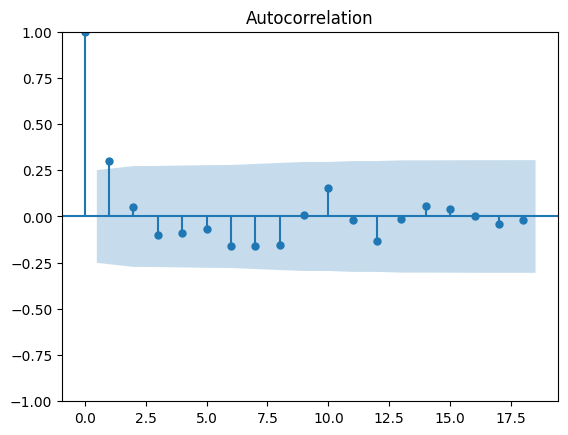

In [161]:
from statsmodels.graphics.tsaplots import plot_acf

# calculating residuals - the difference between the actual and predicted values (error)
comp_test["residuals"] = comp_test["Actual"] - comp_test["Predictions"]
comp_test["abs_residuals"] = abs(comp_test["Actual"] - comp_test["Predictions"])

# plotting the autocorrelation of the residuals
plot_acf(comp_test["residuals"].dropna())
plt.show()

Avg error: 7.155321574601971, Avg prediction: 25.914234161376953. That means a 27.6%


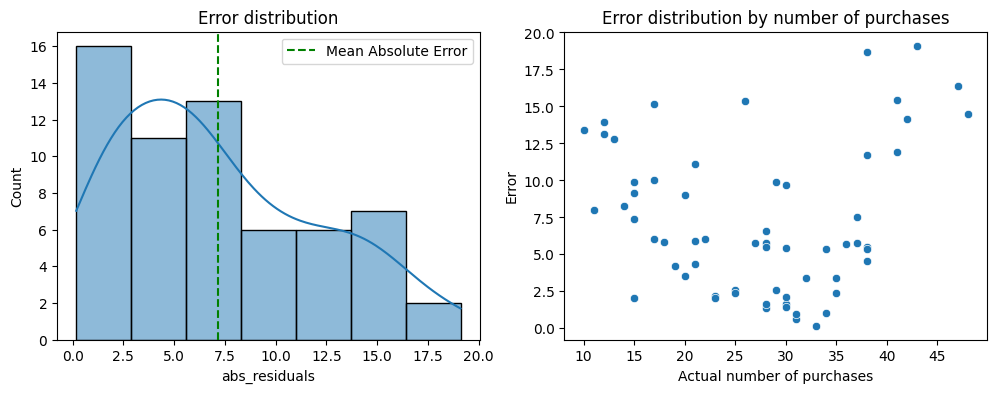

In [165]:
# calculate MAE
average_error = comp_test["abs_residuals"].mean() # mean absolute error
average_prediction = comp_test["Predictions"].mean()
print(f"Avg error: {average_error}, Avg prediction: {average_prediction}. That means a {(average_error/average_prediction)*100:.1f}%")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

# plot the distribution of absolute errors
sns.histplot(comp_test["abs_residuals"], kde=True, ax=ax[0])
ax[0].axvline(x=average_error, color='g', linestyle='--', label='Mean Absolute Error')
ax[0].legend()
ax[0].set_title("Error distribution")

# plot the errors by actual
sns.scatterplot(x=comp_test["Actual"], y=comp_test["abs_residuals"], ax=ax[1])
plt.xlabel("Actual number of purchases")
plt.ylabel("Error")
ax[1].set_title("Error distribution by number of purchases")

plt.show()

As we can see, most of the prediction errors differ from the actual values by between 0 and 5 orders, with an average error of 7 orders.

We also observe that the model performs better when predicting mid-range values, whereas it struggles more with extremely high or low values.

This is particularly problematic in the low-value predictions, where the percentage error is significantly higher than the overall average of 27.6%.

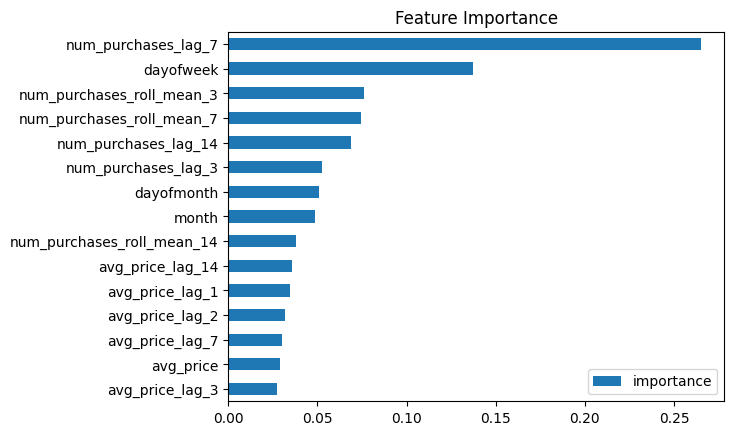

In [ ]:
# create and show feature importance plot
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Although the feature importance analysis suggests that price-related variables do not play a major role in the model, we decided to proceed with a price optimization. This decision is based on previous experience, where a similar analysis provided valuable business insights and actionable recommendations that significantly contributed to strategic decision-making.



## Price Optimization

The idea behind this analysis is to simulate different price points for the same product, observe the corresponding predicted sales volumes, and try to maximize the equation: **income = price × number of purchases**.

Our initial hypothesis is that, as we increase the price, the model would predict fewer sales — and at some point, the price would be too high, leading to such a drop in sales that the overall income would begin to decrease.

In [166]:
# columns to be used for the price multiplier analysis
price_columns = ["avg_price", "avg_price_lag_1", "avg_price_lag_2", "avg_price_lag_3", "avg_price_lag_7", "avg_price_lag_14"]

# create a list of multipliers to be used in the analysis
multipliers = list(np.arange(1, 2, 0.1))

X_test_price = X_test.copy()
num_purchases = []
income = []

# calculating the number of purchases and income for each multiplier
for m in multipliers:
    X_test_price[price_columns] = X_test_price[price_columns] * m
    y_pred = reg.predict(X_test_price)

    num_purchases_value = y_pred.sum()
    num_purchases.append(num_purchases_value)

    income_value = (y_pred * X_test_price["avg_price"]).sum()
    income.append(income_value)
    
    print(f"Multiplier: {m:.1f}, Predicted Purchases: {num_purchases_value}, Income: {income_value}")


Multiplier: 1.0, Predicted Purchases: 1580.768310546875, Income: 201824.76386032227
Multiplier: 1.1, Predicted Purchases: 1585.3590087890625, Income: 222364.3872421561
Multiplier: 1.2, Predicted Purchases: 1583.09765625, Income: 265325.51377002225
Multiplier: 1.3, Predicted Purchases: 1564.7083740234375, Income: 340894.1379169453
Multiplier: 1.4, Predicted Purchases: 1569.3140869140625, Income: 479210.8008346445
Multiplier: 1.5, Predicted Purchases: 1565.119873046875, Income: 717786.7755913524
Multiplier: 1.6, Predicted Purchases: 1565.0501708984375, Income: 1148407.4312809634
Multiplier: 1.7, Predicted Purchases: 1565.0501708984375, Income: 1952292.6331776388
Multiplier: 1.8, Predicted Purchases: 1565.0501708984375, Income: 3514126.7397197513
Multiplier: 1.9, Predicted Purchases: 1565.0501708984375, Income: 6676840.805467529


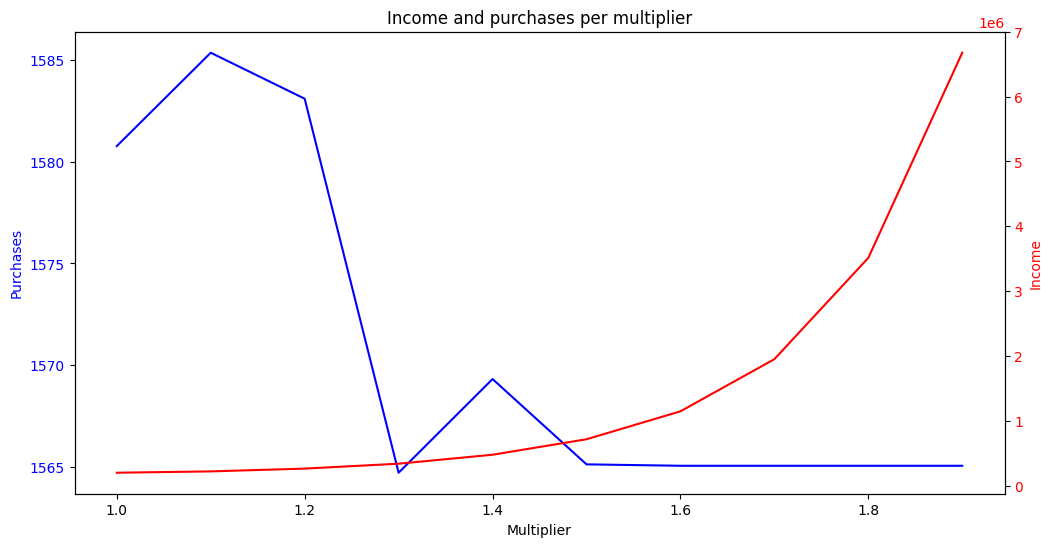

In [167]:
# plot multipliers vs purchases and income
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(multipliers, num_purchases, color='blue', label='Purchases')
ax1.set_ylabel('Purchases', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()

ax2.plot(multipliers, income, color='red', label='Income')
ax2.set_ylabel('Income', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax1.set_title('Income and purchases per multiplier')
ax1.set_xlabel('Multiplier')

plt.show()

However, as we observed in the plot, this expected pattern did not occur. While the model does predict fewer sales when the price increases, the drop is minimal.

This results in a situation where increasing the price almost always appears beneficial in terms of revenue, since the predicted sales volume does not decrease significantly.

This behavior can be explained by the model’s limited sensitivity to price-related features, likely due to a lack of sufficient price variability or low sales volume per price point in the training data. This is a common issue in forecasting algorithms when most of the predictive power comes from time-based features or recent purchase trends, rather than from pricing information.